# Convergence plot for Oscillatory model

In [1]:
import numpy as np
import random
import bayesflow as bf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM

C:\Users\henry\missingness2\bayesflow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def batch_prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


def batch_simulator(prior_samples, n_obs=41, t_end=10, sigma=0.05, missing_max=21, **kwargs):   
    """Simulate multiple oscillatory model data sets with missing values and binary indicator augmentation""" 

    n_sim = prior_samples.shape[0]   # batch size    
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_obs observations
    time_points = np.linspace(0, t_end, n_obs)
    
    for m in range(n_sim):        
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data   

In [3]:
model = bf.simulation.GenerativeModel(batch_prior, batch_simulator, prior_is_batched=True, simulator_is_batched=True)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 41, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [4]:
workflows = ['./Osc_augment01_LSTM(128)_ckpts', './Osc_augment01_trafo_ckpts', 
             './Osc_timelabels_LSTM(128)_ckpts', './Osc_timelabels_trafo_ckpts']
workflows_name = ['Augment by 0/1 (LSTM(128))', 'Augment by 0/1 (transformer)',
                  'Time labels (LSTM(128))', 'Time labels (transformer)']

In [5]:
# Load trained networks & losses
losses = []

for i in range(len(workflows)):
    if i==0 or i==2:
        summary_net = LSTM(128)
    else:
        summary_net = bf.networks.TimeSeriesTransformer(
                input_dim=2, 
                attention_settings=dict(num_heads=2, key_dim=16),
                dense_settings=dict(units=64, activation='relu'),
                )
    inference_net = bf.networks.InvertibleNetwork(num_params=2, num_coupling_layers=4)
    amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)
    trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, checkpoint_path = workflows[i])
    loss_object = trainer.train_online(epochs=0, iterations_per_epoch=0, batch_size=128)
    loss_iteration = loss_object['train_losses'].to_numpy().reshape((300,1000))
    loss_epoch = np.mean(loss_iteration, axis=-1)
    losses.append(loss_epoch)

INFO:root:Loaded loss history from ./Osc_augment01_LSTM(128)_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_augment01_LSTM(128)_ckpts\memory.pkl
INFO:root:Networks loaded from ./Osc_augment01_LSTM(128)_ckpts\ckpt-300
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Loaded loss history from ./Osc_augment01_trafo_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_augment01_trafo_ckpts\memory.pkl
INFO:root:Networks loaded from ./Osc_augment01_trafo_ckpts\ckpt-300
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Loaded loss history from ./Osc_timelabels_LSTM(128)_ckpts\history_300.pkl.
INFO:root:Loaded simulation memory from ./Osc_timelabels_LSTM(128)_ckpts\memory.pkl
INFO:root:Networks loaded from ./Osc_timelabels_LSTM(128)_ckpts\ckpt-300
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Loaded loss history from ./

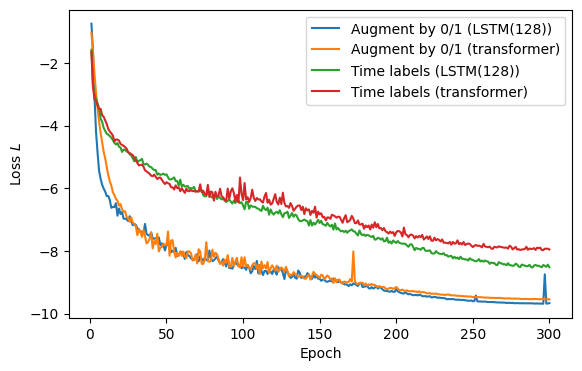

In [6]:
fig = plt.figure(figsize=(6.5, 4))

for i in range(len(workflows_name)):
    plt.plot(np.arange(1,301), losses[i], label=workflows_name[i])
    
plt.xlabel('Epoch')
plt.ylabel('Loss $L$')
plt.legend()
plt.show()
fig.savefig("./figures/Osc_convergence.png", dpi=300, bbox_inches='tight')
fig.savefig("./figures/Osc_convergence.pdf", bbox_inches='tight')